In [98]:
%load_ext autoreload
%autoreload 2

import llminference as L
import transformers
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from torch import Tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
adapter = L.Adapter.from_pretrained("meta-llama/Llama-2-7b-hf")
# adapter = L.Adapter.from_pretrained("EleutherAI/pythia-6.9b")
original_model = adapter.model
data = L.qa.SQuAD.data()
examples = [L.qa.add_few_shot_prompt(data[i], k=1, prompt_template=L.qa.get_default_prompt_template(adapter.model.config._name_or_path, shots=1)) for i in range(1000)]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset squad (/nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-03400b5d173ab796.arrow
Loading cached shuffled indices for dataset at /nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-c374d8616db3e9e0.arrow


In [50]:
adapter.model = original_model
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:32<00:00, 32.38s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million.',
  'match': True,
  'prefill_length': 1507}]

In [55]:
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder=False, score="sparse_q", rank=128,
))
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:34<00:00, 34.50s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million\n',
  'match': True,
  'prefill_length': 1507}]

In [56]:
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder="v2", score="sparse_q", rank=128,
))
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:33<00:00, 33.36s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million.',
  'match': True,
  'prefill_length': 1507}]

In [75]:
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder="true", score="sparse_q", rank=32,
))
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:32<00:00, 32.32s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million.',
  'match': True,
  'prefill_length': 1507}]

In [87]:
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder="v2", score="sparse_q", rank=32,
))
for i in [0, 1]:
    adapter.model.model.layers[i].self_attn = original_model.model.layers[i].self_attn
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:37<00:00, 37.10s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million.',
  'match': True,
  'prefill_length': 1507}]

In [96]:
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder="v2", score="sparse_q", rank=32,
))
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:33<00:00, 33.28s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over over over over over over',
  'match': False,
  'prefill_length': 1507}]

In [129]:
# HACK: use `rank` instead of `head_size`
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder="v2", score="sparse_q", rank=32,
))
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:33<00:00, 33.64s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million\n',
  'match': True,
  'prefill_length': 1507}]

In [228]:
# HACK: use `head_size` scaled by q-coverage
adapter.model = L.ann_attention.convert(original_model, L.ann_attention.Settings(
    k=128, local_k=32, add_remainder="v2", score="sparse_q", rank=32,
))
out = list(L.qa.evaluate(adapter, [examples[i] for i in [66]], batch_size=1, output_token_limit=6))
out

Evaluating meta-llama/Llama-2-7b-hf: 100%|██████████| 1/1 [00:42<00:00, 42.59s/it]


[{'id': '56bebe873aeaaa14008c9340',
  'output': 'over $40 million.',
  'match': True,
  'prefill_length': 1507}]

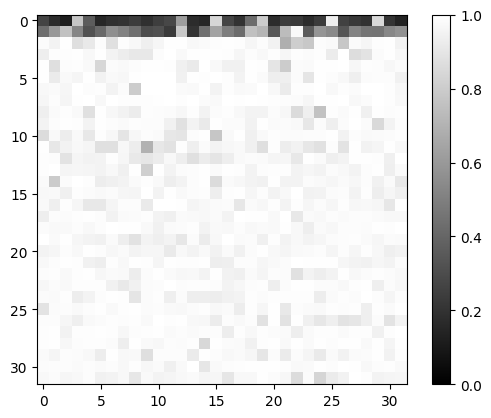

In [76]:
true_kv_weight = torch.stack([layer.self_attn.ann.log[0].kv_weight.squeeze([0, 2]) for layer in adapter.model.model.layers])
plt.imshow(true_kv_weight, vmin=0, vmax=1, cmap="gray")
plt.colorbar()

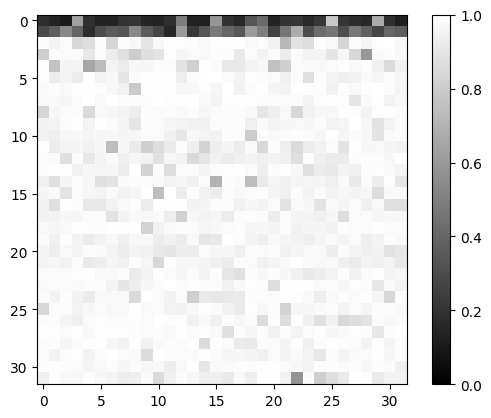

In [97]:
low_rank_kv_weight = torch.stack([layer.self_attn.ann.log[0].kv_weight.squeeze([0, 2]) for layer in adapter.model.model.layers])
plt.imshow(low_rank_kv_weight, vmin=0, vmax=1, cmap="gray")
plt.colorbar()

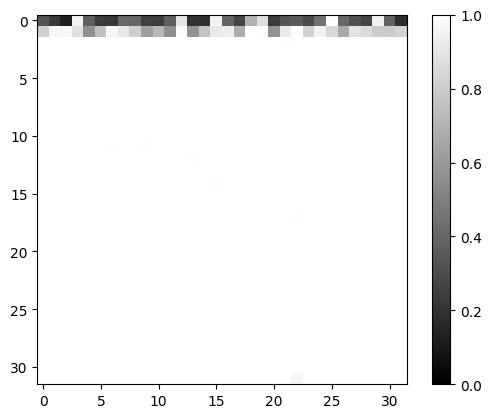

In [130]:
low_rank_lowtemp_kv_weight = torch.stack([layer.self_attn.ann.log[0].kv_weight.squeeze([0, 2]) for layer in adapter.model.model.layers])
plt.imshow(low_rank_lowtemp_kv_weight, vmin=0, vmax=1, cmap="gray")
plt.colorbar()

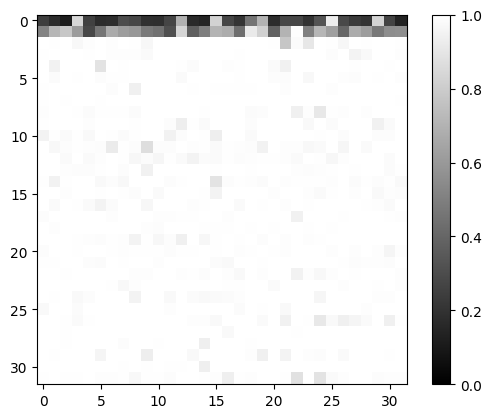

In [229]:
low_rank_qcov_kv_weight = torch.stack([layer.self_attn.ann.log[0].kv_weight.squeeze([0, 2]) for layer in adapter.model.model.layers])
plt.imshow(low_rank_qcov_kv_weight, vmin=0, vmax=1, cmap="gray")
plt.colorbar()

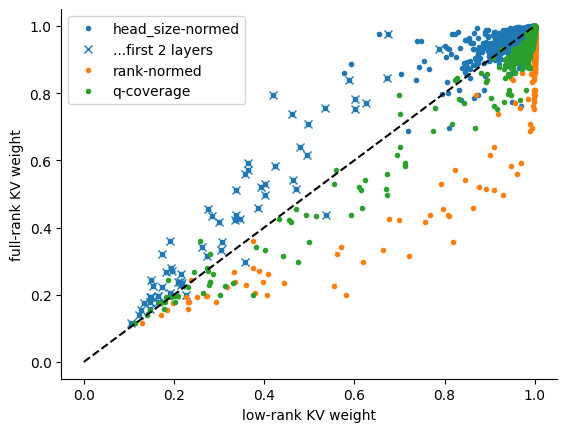

In [243]:
split = 2
h0, h1, h2 = sns.color_palette(n_colors=3)
plt.plot(low_rank_kv_weight.flatten(), true_kv_weight.flatten(), '.', color=h0, label=f"head_size-normed")
plt.plot(low_rank_kv_weight[:split].flatten(), true_kv_weight[:split].flatten(), 'x', color=h0, label=f"...first {split} layers")
plt.plot(low_rank_lowtemp_kv_weight.flatten(), true_kv_weight.flatten(), '.', color=h1, label=f"rank-normed")
plt.plot(low_rank_qcov_kv_weight.flatten(), true_kv_weight.flatten(), '.', color=h2, label=f"q-coverage-normed")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("low-rank KV weight")
plt.ylabel("full-rank KV weight")
plt.legend()
sns.despine()

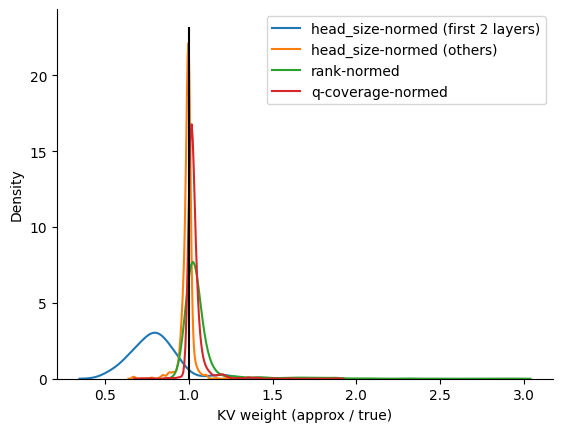

In [245]:
sns.kdeplot((low_rank_kv_weight[:split]/true_kv_weight[:split]).flatten(), label=f"head_size-normed (first {split} layers)")
sns.kdeplot((low_rank_kv_weight[split:]/true_kv_weight[split:]).flatten(), label="head_size-normed (others)")
sns.kdeplot((low_rank_lowtemp_kv_weight/true_kv_weight).flatten(), label=f"rank-normed")
sns.kdeplot((low_rank_qcov_kv_weight/true_kv_weight).flatten(), label=f"q-coverage-normed")
plt.vlines(1, *plt.ylim(), "k")
plt.legend()
plt.xlabel("KV weight (approx / true)")
sns.despine()

Text(0.5, 0, 'Q component coverage (k=32 /128)')

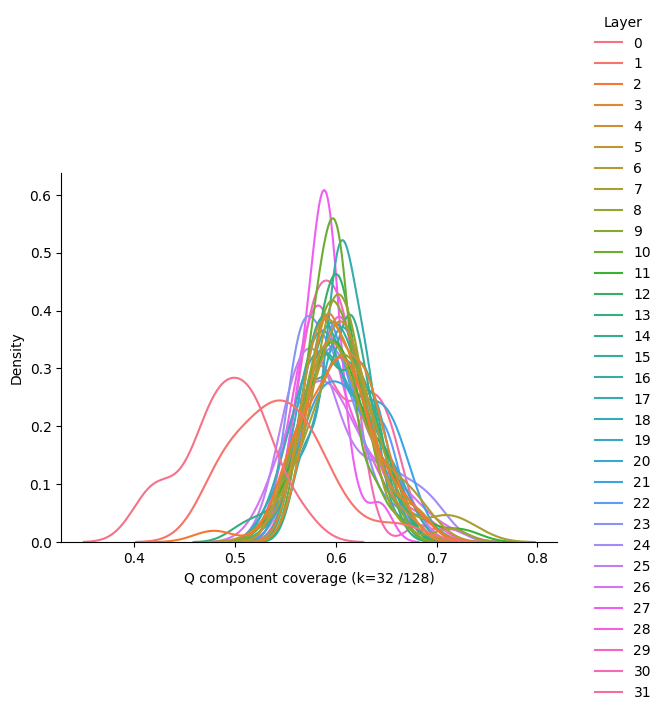

In [212]:
k = 32
def coverage(q: Tensor, k: int) -> Tensor:
    return q.abs().topk(k).values.sum(-1) / q.abs().sum(-1)
g = sns.kdeplot(torch.stack([coverage(layer.self_attn.ann.log[0].query, k=k).flatten() for layer in adapter.model.model.layers]).T)
sns.despine()
g.legend(labels=list(map(str, range(32))), handles=g.legend_.legend_handles, bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=False, title="Layer")
g.set_xlabel(f"Q component coverage (k={k} /128)")

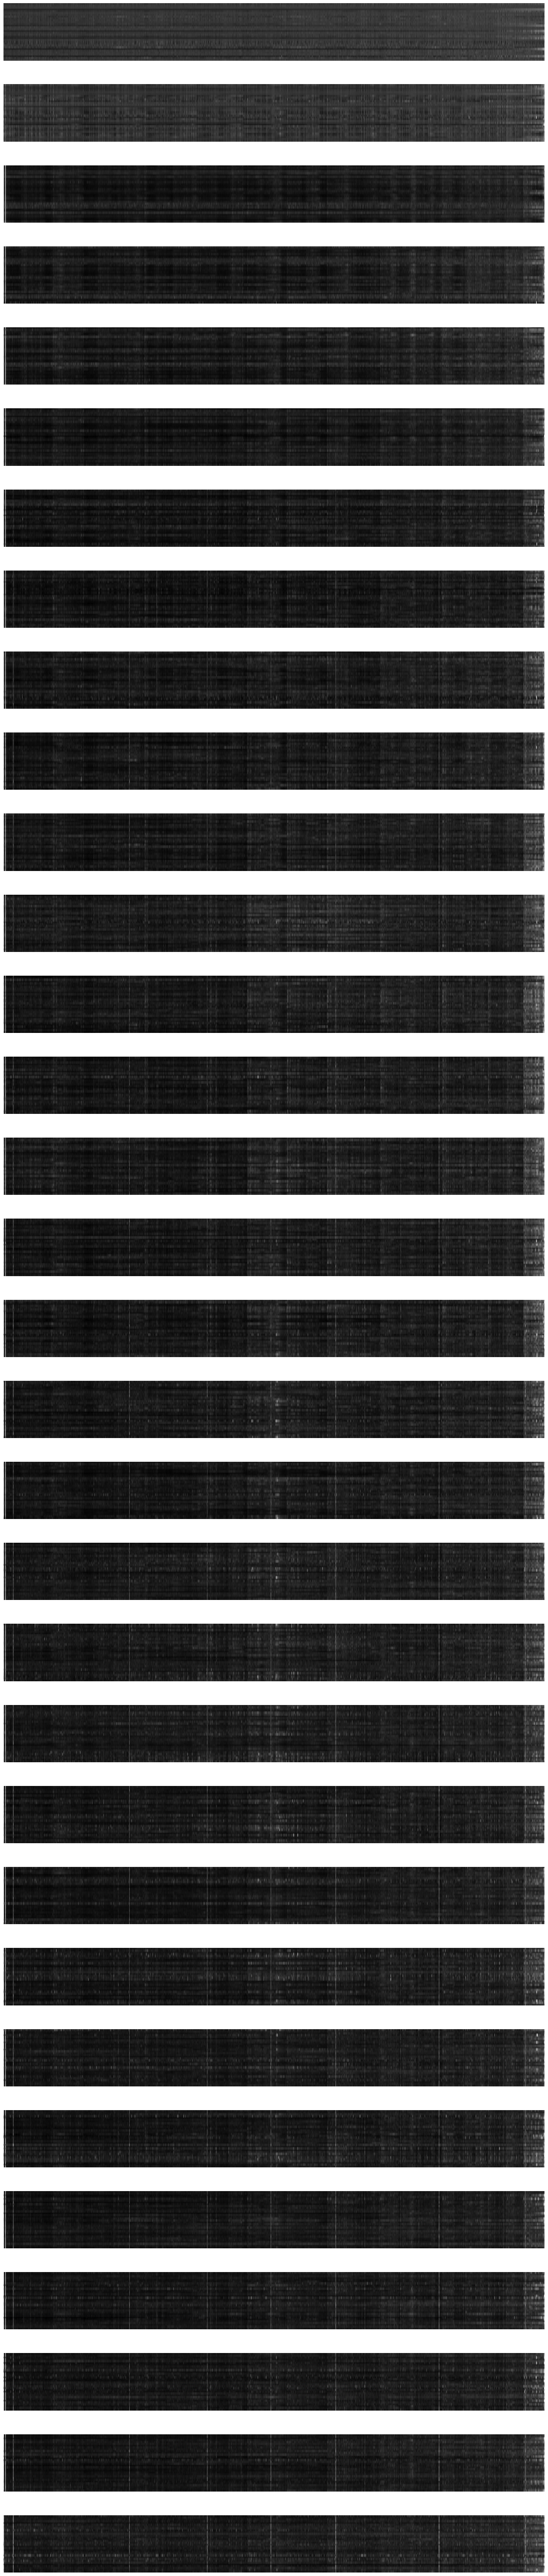

In [128]:
_, axs = plt.subplots(len(adapter.model.model.layers), 1, figsize=(20, 3*len(adapter.model.model.layers)))
for layer, ax in zip(adapter.model.model.layers, axs.flatten()):
    log = layer.self_attn.ann.log[0]
    ax.imshow(torch.softmax((log.query @ log.key.transpose(-1, -2)).div_(128**0.5), -1).squeeze([0, 2]), aspect=5, cmap="gray", norm=matplotlib.colors.PowerNorm(0.2, vmin=0, vmax=1))
    ax.axis("off")